In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
import os

import scipy
import matplotlib

from robot import *
from utils import *
import pybullet as p
import pybullet_data
import networkx as nx
from functools import partial

#import tf_robot_learning as rl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Pybullet

In [5]:
physics_client_id = p.connect(p.GUI)
p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)


In [6]:
p.resetSimulation()

### Setup Robot

In [7]:
robot_urdf = 'urdf/frankaemika_new/panda_arm_rivet.urdf';
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)

plane_id = p.loadURDF('plane.urdf')
pb_joint_indices = np.arange(7)
joint_limits = get_joint_limits(robot_id, pb_joint_indices)


set_q_std = partial(set_q,robot_id, pb_joint_indices)

vis_traj_std = partial(vis_traj, vis_func= set_q_std)

### Setup Obstacles

In [8]:
is_simple = False
obs_ids = []
rgbacolor = (0,0,1,0)
if is_simple:
    _,_,board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.02, 0.5, 0.3))
    p.resetBasePositionAndOrientation(board_id, (0.6, 0., 0.6), (0,0,0,1))
    obs_ids = [board_id]
else:
    board_id = p.loadURDF('urdf/support.urdf', globalScaling=0.001)
    quat = w2quat(np.array([0,0,-np.pi/2]))
    p.resetBasePositionAndOrientation(board_id, (0.6,-2.2,-.6), quat)
    
    offset = 0.
    #p.resetBasePositionAndOrientation(board_id, (0.50,-2.18,-.62), quat)

    _,_,main_board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.02, 0.7, 0.25), rgbaColor=rgbacolor)
    p.resetBasePositionAndOrientation(main_board_id, (0.75-offset, -0.1, 0.67), (0,0,0,1))
    obs_ids += [main_board_id]
    
    _,_,bottom_board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.15, 0.7, 0.02), rgbaColor=rgbacolor)

    p.resetBasePositionAndOrientation(bottom_board_id, (0.60-offset, -0.1, 0.44), (0,0,0,1))
    obs_ids += [bottom_board_id]

    _,_,top_board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.17, 0.7, 0.02), rgbaColor=rgbacolor)

    p.resetBasePositionAndOrientation(top_board_id, (0.59-offset, -0.1, 0.9), (0,0,0,1))
    obs_ids += [top_board_id]

    _,_,middle_board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.17, 0.02, 0.25), rgbaColor=rgbacolor)

    p.resetBasePositionAndOrientation(middle_board_id, (0.59-offset, -0.08, 0.67), (0,0,0,1))
    obs_ids += [middle_board_id]

    _,_,left_board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.17, 0.02, 0.25), rgbaColor=rgbacolor)

    p.resetBasePositionAndOrientation(left_board_id, (0.59-offset, 0.6, 0.67), (0,0,0,1))
    obs_ids += [left_board_id]

    _,_,right_board_id = create_primitives(p.GEOM_BOX, halfExtents=(0.17, 0.02, 0.25), rgbaColor=rgbacolor)

    p.resetBasePositionAndOrientation(right_board_id, (0.59-offset, -0.75, 0.67), (0,0,0,1))
    obs_ids += [right_board_id]

### Setup targets

In [9]:
#ys = np.arange(-0.45, 0.46, 0.20)
ys = np.array([ -0.55, -0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2,  0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
zs = np.arange(0.55, 0.81, 0.05)
#ys = np.array([-0.45, -0.25,  0.15,  0.35])
#zs = np.arange(0.6, 0.81, 0.1)
x = 0.6
targets = []
offset = -0.05
for y in ys:
    for z in zs:
        target = np.array([x, y,z])
        targets += [target]
        _,_,target_id = create_primitives(p.GEOM_BOX, halfExtents=(0.03, 0.01, 0.01), rgbaColor=(1,0,0,1))
        p.resetBasePositionAndOrientation(target_id, targets[-1], (0,0,0,1))
        targets[-1][0] += offset

targets = np.array(targets)

### RRT

In [10]:
rob_sampler = sampler(joint_limits)
rob_col_checker = col_checker(robot_id, pb_joint_indices, [ plane_id] + obs_ids)
rob_interpolator = interpolator()

In [11]:
rrt = BiRRT(7, rob_sampler, rob_col_checker, rob_interpolator)

#### Setup IK solver

In [12]:
class CostProjector():
    def __init__(self, cost):
        self.cost = cost
    
    def project(self, q, ftol = 1e-12, gtol = 1e-12, disp = 1, maxiter = 1000 ):
        #update the variables
        self.cost.reset_iter()

        status = False
        res = minimize(self.cost.calc,q,method='l-bfgs-b', jac=self.cost.calcDiff,  options={'ftol':ftol, 'gtol':gtol, 'disp':disp, 'maxiter':maxiter})      
        res = {'stat':status, 'q':  self.cost.qs[-1], 'qs': self.cost.qs, 'nfev': self.cost.nfev, 'feval': self.cost.feval}
        return res

#### Load model in pinocchio

In [13]:
robot_urdf = 'urdf/frankaemika_new/panda_arm_franka.urdf';
rmodel = pin.buildModelFromUrdf(robot_urdf)
rdata = rmodel.createData()

pin_frame_names = [f.name for f in rmodel.frames]
ee_frame_id = rmodel.getFrameId('panda_grasptarget_hand')
pb_ee_frame_id = 7

#### Set IK Solver

In [14]:
x = np.array([0.4,0.2,0.4])
w = np.array([0.,np.pi/2,0.])
pose = np.concatenate((x,w))

#define joint limit cost
bound_cost = CostBound(joint_limits)
#define pose cost
pos_cost = CostFrame(rmodel, rdata, pose, ee_frame_id, np.array([1,1,1,1,1,1]))

#Define IK solver
cost_sum_ik = CostSum()
cost_sum_ik.addCost(pos_cost, 50., 'pose_cost', 1e-12)
cost_sum_ik.addCost(bound_cost, 100., 'joint_limit', 1e-12)
ik_solver = CostProjector(cost_sum_ik)

# Load Data

In [15]:
data = np.load('data/data_holes.npy', allow_pickle=True)[()]

In [16]:
targets = data['targets']

qs_raw = data['q']

disp = np.linalg.norm(data['disp'], axis=2)
disp = data['disp'][:,:,0]

#### Filter the data

In [17]:
qs = []
disps = []
count_col = 0
for i,qset in enumerate(qs_raw):
    qlist = []
    displist = []
    for j,q in enumerate(qset):
        if rob_col_checker.check_collision(q) is False:
            qlist += [q]
            displist += [disp[i][j]*1000]
        else:
            count_col += 1 
            print('Collision',count_col)
    qlist = np.array(qlist)
    displist = np.array(displist)

    qs += [qlist]
    disps += [displist]
clear_output()

#### Visualize the data

### Construct Graph & Solve TSP

In [15]:
from rtsp import *

In [16]:
graph = from_coordinate_list(targets, euclidean_metric)

path = two_opt(graph)

### Construct the c-space graph

In [17]:
max_config = 50

q_init = np.array([ 0.73170025, -1.10558688,  0.22936525, -2.28523573, -1.07928728,
        2.17303381, -1.24231352])[None,:]

In [18]:
class time_struct():
    def __init__(self):
        self.select_config = 0
        self.plan = 0
        self.postplan = 0

In [19]:
def plan_motion(q_init, path, qs, disps, max_config, w_disp = 20, max_try = 20):
    comp_time = time_struct()
    tic = time.time()
    print('Obtaining configurations in the required order')
    qs_new = [q_init]
    disps_new = [np.array([0])]
    for idx in path:
        qs_new += [qs[idx][:max_config]]
        disps_new += [disps[idx][:max_config]]
    qs_new += [q_init]
    disps_new += [np.array([0])]
    
    print("Construct cgraph")
    cgraph = construct_cgraph(qs_new, disps_new, w_disp = w_disp)
    
    print('Plan configuration path')
    cpath = nx.dijkstra_path(cgraph, 0, len(cgraph.nodes()) - 1)
    traj, total_disp = extract_traj(cgraph, cpath)
    clear_output()
    toc = time.time()
    
    comp_time.select_config = toc-tic
    comp_time.plan = 0
    comp_time.postplan = 0
    
    print('Plan motion')
    trajs = []
    total_dist = 0
    for i in range(0,len(cpath)-1):
        q = cgraph.nodes[cpath[i]]['value']
        qn = cgraph.nodes[cpath[i+1]]['value']
        tic = time.time()
        traj,_,_ = rrt.plan(q,qn)
        toc = time.time()
        comp_time.plan += toc-tic
        shortpath = rrt.shortcut_path(traj, max_try = max_try)
        shorttraj = np.array(traj)[shortpath]
        shortpath2 = rrt.shortcut_path_old(shorttraj,step_length=0.05)
        shorttraj2 = rrt.interpolate_traj(shortpath2, shorttraj)
        toc2 = time.time()
        comp_time.postplan += toc2-toc
        trajs += [shorttraj2]
        total_dist += calc_dist(shorttraj2)
        clear_output()

    clear_output()
    print('Planning time:{}, {}, {}'.format(comp_time.select_config, comp_time.plan, comp_time.postplan))
    return trajs, total_dist, total_disp, comp_time

In [20]:
def plan_motion_max(q_init, path, qs, disps, max_config, w_disp = 0.3, max_try = 20):
    comp_time = time_struct()
    tic = time.time()
    print('Obtaining configurations that minimizes d') 
    qs_new = [q_init[0]]
    disps_new = [np.array([0])]
    total_disp = 0
    for idx in path:
        disp = disps[idx]
        idx_min = np.argmin(disp[:max_config])
        total_disp += disp[idx_min]
        qs_new += [qs[idx][idx_min]]
        disps_new += [disps[idx][idx_min]]
    disps_new += [np.array([0])]
    qs_new += [q_init[0]]
    toc = time.time()

    comp_time.select_config = toc-tic
    comp_time.plan = 0
    comp_time.postplan = 0

    
    clear_output()
    print('Plan the motion')
    trajs = []
    total_dist = 0
    for i in range(len(path)-1):
        q = qs_new[i]
        qn = qs_new[i+1]
        tic = time.time()
        traj,_,_ = rrt.plan(q,qn)
        toc = time.time()
        comp_time.plan += toc-tic
        
        shortpath = rrt.shortcut_path(traj, max_try = max_try)
        shorttraj = np.array(traj)[shortpath]
        shortpath2 = rrt.shortcut_path_old(shorttraj,step_length=0.05)
        shorttraj2 = rrt.interpolate_traj(shortpath2, shorttraj)
        #shorttraj2 = rrt.interpolate_traj(shortpath, traj)
        toc2 = time.time()
        comp_time.postplan += toc2-toc
        trajs += [shorttraj2]
        total_dist += calc_dist(shorttraj2)
        clear_output()


    clear_output()
    print('Planning time:{}, {}, {}'.format(comp_time.select_config, comp_time.plan, comp_time.postplan))
    return trajs, total_dist, total_disp, comp_time

#### Determine the weight

#### Plan using RTSP

In [21]:
num_configs = [1, 5, 10, 20, 50, 75, 100, 200]
num_configs = num_configs[6:7]

In [22]:
rtsp_fixed_dists = dict()
rtsp_fixed_disps = dict()
rtsp_fixed_trajs = dict()
rtsp_fixed_time = dict()

In [23]:
for n in num_configs:
    print('Planning with {} configs'.format(n))
    rtsp_fixed_trajs[n], rtsp_fixed_dists[n], rtsp_fixed_disps[n], rtsp_fixed_time[n] = plan_motion(q_init, np.arange(len(path)), qs, disps, n, w_disp = 2000.)

Planning time:2.5477070808410645, 2.1790497303009033, 4.8677802085876465


In [230]:
set_q_std(q_init[0])

In [231]:
for traj in rtsp_fixed_trajs[100]:
    vis_traj_std(traj,dt=0.02)
    time.sleep(0.1)

In [75]:
rtsp_fixed_dists[100], rtsp_fixed_disps[100]/84

(63.89606845773394, 0.0002451692914927692)

In [92]:
set_q_std(rtsp_fixed_trajs[n][1][0])

In [71]:
rtsp_fixed_config_time = []
rtsp_fixed_plan_time = []
rtsp_fixed_postplan_time = []
for n in num_configs:
    rtsp_fixed_config_time += [rtsp_fixed_time[n].select_config]
    rtsp_fixed_plan_time += [rtsp_fixed_time[n].plan]
    rtsp_fixed_postplan_time += [rtsp_fixed_time[n].postplan]

In [72]:
data = dict()
data['rtsp_fixed'] = [rtsp_fixed_dists, rtsp_fixed_disps, rtsp_fixed_trajs, rtsp_fixed_config_time,rtsp_fixed_plan_time, rtsp_fixed_postplan_time ]
data['num_configs'] = num_configs
np.save('data/rivet_planning' + str(len(qs)) + '.npy', data, allow_pickle=True)

#### Plan using Baseline

In [222]:
selmax_dists = dict()
selmax_disps = dict()
selmax_trajs = dict()
selmax_time  = dict()
for n in num_configs:
    print('Planning with {} configs'.format(n))
    selmax_trajs[n], selmax_dists[n], selmax_disps[n], selmax_time[n] = plan_motion_max(q_init,  np.arange(len(path)), qs, disps, n)

Planning time:0.0007295608520507812, 7.56900429725647, 34.09576916694641


In [232]:
set_q_std(q_init[0])

In [233]:
for traj in selmax_trajs[100]:
    vis_traj_std(traj,dt=0.02)
    time.sleep(0.1)

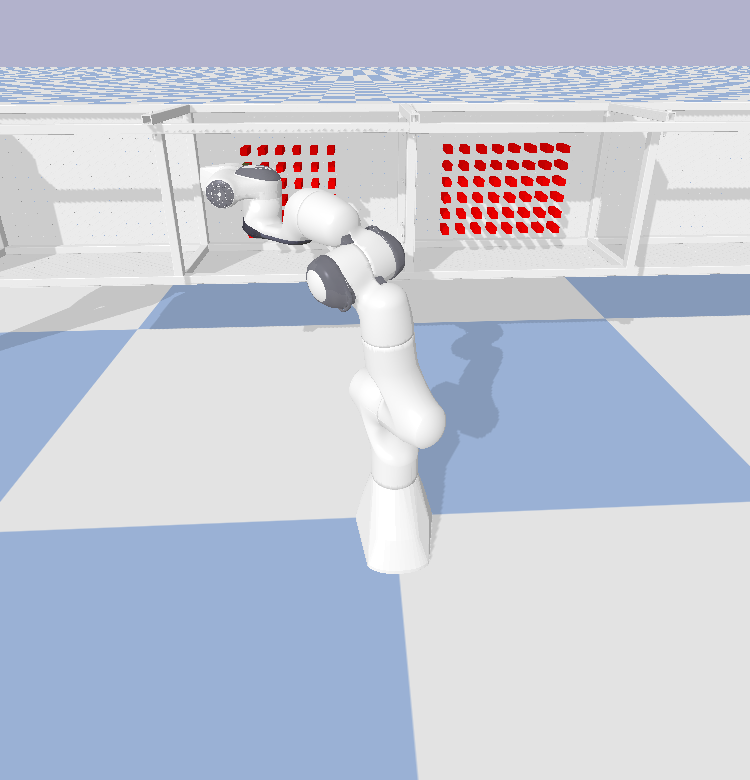

In [240]:
save_screenshot(150,300,900, 1200, 'try.png')

In [39]:
for n in num_configs:
    print(n, selmax_dists[n], selmax_disps[n], selmax_time[n].postplan)

1 669.4416406827673 0.03358834725020188 63.089629888534546
5 477.4983032134316 0.02469748207545308 38.259376525878906
10 429.5098856074272 0.021454115358920944 31.973226070404053
20 416.80077563122074 0.01957408373343128 36.82099986076355
50 419.2487642347558 0.017989704396370598 35.77718639373779
75 391.8141450395147 0.017361030760554286 31.973713874816895
100 394.0534919731281 0.016791441975527732 28.959649085998535
200 463.9406768627587 0.016082212514589855 35.65513300895691


#### Plan using Random

#### Save Data

In [76]:
rtsp_fixed_config_time = []
rtsp_fixed_plan_time = []
rtsp_fixed_postplan_time = []

selmax_config_time = []
selmax_plan_time = []
selmax_postplan_time = []

# selrandom_config_time = []
# selrandom_plan_time = []
# selrandom_postplan_time = []

for n in num_configs:
    rtsp_fixed_config_time += [rtsp_fixed_time[n].select_config]
    rtsp_fixed_plan_time += [rtsp_fixed_time[n].plan]
    rtsp_fixed_postplan_time += [rtsp_fixed_time[n].postplan]

    selmax_config_time += [selmax_time[n].select_config]
    selmax_plan_time += [selmax_time[n].plan]
    selmax_postplan_time += [selmax_time[n].postplan]

#     selrandom_config_time += [selrandom_time[n].select_config]
#     selrandom_plan_time += [selrandom_time[n].plan]
#     selrandom_postplan_time += [selrandom_time[n].postplan]
rtsp_fixed_config_time = np.array(rtsp_fixed_config_time)
rtsp_fixed_plan_time = np.array(rtsp_fixed_plan_time)
rtsp_fixed_postplan_time = np.array(rtsp_fixed_postplan_time)

selmax_config_time = np.array(selmax_config_time)
selmax_plan_time = np.array(selmax_plan_time)
selmax_postplan_time = np.array(selmax_postplan_time)

In [77]:
data = dict()
data['rtsp_fixed'] = [rtsp_fixed_dists, rtsp_fixed_disps, rtsp_fixed_trajs, rtsp_fixed_config_time,rtsp_fixed_plan_time, rtsp_fixed_postplan_time ]
data['baseline'] = [selmax_dists, selmax_disps, selmax_trajs, selmax_config_time, selmax_plan_time, selmax_postplan_time]
#data['random'] = [selrandom_dists, selrandom_disps, selrandom_trajs, selrandom_config_time, selrandom_plan_time, selrandom_postplan_time]
data['num_configs'] = num_configs
np.save('data/rivet_planning' + str(len(qs)) + '.npy', data, allow_pickle=True)

#### Visualize

In [213]:
for traj in rtsp_fixed_trajs[20]:
    vis_traj_std(traj,dt=0.02)
    time.sleep(0.1)

## Comparison

### Follow the hole ordering & Select the lowest displacement

In [348]:
q_init = np.array([ 2.80610866, -1.43654197,  2.84295035, -1.50896751,  1.38798534,
        2.49565709,  2.56055424])
qs_new = []
for idx in path:
    qs_new += [qs[idx][0]]

In [349]:
qs_new = np.array(qs_new)

In [350]:
graph3 = from_coordinate_list(qs_new, euclidean_metric)
path3 = two_opt(graph3)

In [354]:
qnodes = []
for i in path3:
    set_q_std(qs_new[i])
    time.sleep(0.3)
    qnodes += [qs_new[i]]

In [361]:
tic = time.time()
trajs = []
for i in range(len(path3)-1):
    idx = path3[i]
    idx_n = path3[i+1]
    n = qnodes[idx]
    n_next = qnodes[idx_n]
    set_q_std(n)
    #input()
    set_q_std(n_next)
    #input()
    
    q = n
    qn = n_next
    traj,_,_ = rrt.plan(q,qn)
    shortpath = rrt.shortcut_path(traj)
    shorttraj = rrt.interpolate_traj(shortpath, traj)
    print(len(traj))
    print(len(shortpath))
    trajs += [shorttraj]

clear_output()
toc = time.time()
print('Planning time:{}'.format(toc-tic))

Planning time:37.39302349090576


## IK for the targets

#### Try IK Solver

#### Save Data